In [235]:
#WIP Dont run this block
# Create Spark Session

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, regexp_replace
from pyspark.ml.feature import StringIndexer

spark = SparkSession \
        .builder \
        .appName("Read Voter File Data") \
        .getOrCreate()
# global variables 
class_bucket_name = "winter-2024-voter-file"
local_bucket_name = "pstat135-final-project1"
class_folder_name = "VM2Uniform"  

""" Use these functions to [read/write] [parquet files/data frames] [from/to] Google Cloud"""

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, count

def read_parquet_file(spark_session, file_path):
    """
    Reads a Parquet file and returns a Spark DataFrame.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    file_path (str): The path to the Parquet file.

    Returns:
    DataFrame: A Spark DataFrame containing the data from the Parquet file.
    """

    # Read the Parquet file
    df = (
        spark_session.read
        .format("parquet")
        .option("header", "true")
        .option("inferSchema", "true")
        .load(file_path)
    )

    return df


def write_df_to_gcs_parquet(spark_session, df, bucket_name, file_path):
    """
    Writes a Spark DataFrame to a Google Cloud Storage bucket as a Parquet file.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    df (DataFrame): The Spark DataFrame to write.
    bucket_name (str): The name of the Google Cloud Storage bucket.
    file_path (str): The file path within the bucket where the Parquet file will be saved.
    """
    
    # Define the GCS path
    gcs_path = f"gs://{bucket_name}/data_cleaned/{file_path}"

    # Write the DataFrame as a Parquet file to GCS
    df.write.parquet(gcs_path, mode='overwrite')
    

def list_content(bucket_name):
    """
    Lists all the blobs in the bucket.
    
    Parameters: 
    bucket_name (str): The name of the Google Cloud Storage bucket. 
    """
    storage_client = storage.Client()
    content = storage_client.list_blobs(bucket_name)
    
    for file in content:
        print(file.name)

def column_missing_percentage1(df):
    """
    Calculate the percentage of missing values for each column in the DataFrame.
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with two columns: 'Column_Name' and 'Missing_Percentage'.
    """
    missing_percentage_data = []
    total_count = df.count()
    
    for c in df.columns:
        missing_count = df.filter(col(c).isNull() | (col(c) == '')).count()
        missing_percentage = (missing_count / total_count) * 100
        missing_percentage_data.append((c, missing_percentage))
    
    missing_percentage_df = spark.createDataFrame(missing_percentage_data, ["Column_Name", "Missing_Percentage"])
    return missing_percentage_df


def clean_dataset(df):
    """
    Clean our dataset by applying the following: 
        1) Convert 'CommercialData_EstHomeValue' from string to int data type
        2) Extract state from `LALVOTERID`
        3) Convert `Voters_Gender` into a 0/1 depending on Gender
        4) Fill missing values in 'General_2020', 'PresidentialPrimary_2020', 'Primary_2020'
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with the necessary columns. 
    """
    df_num = df.withColumn("CommercialData_EstHomeValue_in_Dollars", regexp_replace("CommercialData_EstHomeValue", "\\$", "").cast("int"))    
    df_with_state = df_num.withColumn("State", col("LALVOTERID").substr(4, 2))
    cleaned_df = df_with_state.filter(df_with_state.Voters_Gender.isNotNull())
    converted_df = cleaned_df.withColumn("Gender", when(col("Voters_Gender") == "M", 1).otherwise(0))
    converted_df = converted_df.filter(converted_df.CommercialData_EstimatedHHIncome.isNotNull())
    
    indexer = StringIndexer(inputCol="CommercialData_EstimatedHHIncome", outputCol="CommercialData_EstimatedHHIncome_ctg", handleInvalid="skip")

    # Fit and transform the DataFrame
    model = indexer.fit(converted_df)
    df_categorical = model.transform(converted_df)
    
    df_a = df_categorical.fillna({'General_2020': 'N'})
    df_b = df_a.fillna({'PresidentialPrimary_2020': 'N'})
    df_c = df_b.fillna({'Primary_2020': 'N'})
    
    df_final = df_c.drop("Voters_StateVoterID")
    return df_final

df = clean_dataset(read_parquet_file(spark, "gs://pstat135-final-project1/data_cleaned/dataset_young_demographic"))


In [237]:
df.count()

2940241

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, count

def list_filtered_blobs(bucket_name, folder_name):
    """Lists all the blobs in a specific folder of the bucket that end with '_SUCCESS'."""
    storage_client = storage.Client()
    prefix = folder_name + '/'
    filtered_blobs = []

    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    for blob in blobs:
        if blob.name.endswith("_SUCCESS"):
            # Remove '_SUCCESS' from the file name
            replaced_name = blob.name.replace('_SUCCESS', '')
            
            split_replaced_name = replaced_name.split('/')
            
            cleaned_name = split_replaced_name[1]
            
            if cleaned_name not in filtered_blobs:
                filtered_blobs.append(cleaned_name)

    return filtered_blobs

def aggregate_dataset(files):
    dataframes = []

    for file in files:
        df = read_parquet_file(spark, f"gs://winter-2024-voter-file/VM2Uniform/{file}")
        subset_df = df.filter((df.Voters_Age >= 18) & (df.Voters_Age <= 29))
        sampled_df = subset_df.sample(False, 0.1)  # False for no replacement, 0.1 for 10%
        dataframes.append(sampled_df)

    aggregate_df = dataframes[0]
    for dataframe in dataframes[1:]:
        aggregate_df = aggregate_df.union(dataframe)
        
    return aggregate_df

def read_parquet_file(spark_session, file_path):
    """
    Reads a Parquet file and returns a Spark DataFrame.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    file_path (str): The path to the Parquet file.

    Returns:
    DataFrame: A Spark DataFrame containing the data from the Parquet file.
    """

    # Read the Parquet file
    df = (
        spark_session.read
        .format("parquet")
        .option("header", "true")
        .option("inferSchema", "true")
        .load(file_path)
    )

    return df


In [2]:
from google.cloud import storage
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, regexp_replace
from pyspark.ml.feature import StringIndexer

spark = SparkSession \
        .builder \
        .appName("Read Voter File Data") \
        .getOrCreate()


# global variables 
class_bucket_name = "winter-2024-voter-file"
local_bucket_name = "pstat135-final-project1"
class_folder_name = "VM2Uniform"  

# Use the sample_parquet files and the corresponding dataset to test your code before using the actual dataset
sample_parquet_files = ['VM2Uniform--AK--2021-02-03', 'VM2Uniform--AL--2021-02-04', 'VM2Uniform--AR--2021-03-16']
success_files = list_filtered_blobs(class_bucket_name, class_folder_name)
states = [file.split('--')[1] for file in success_files]
combined_df = aggregate_dataset(success_files)


                                     

24/03/20 07:18:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/03/20 07:18:25 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:18:40 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:18:55 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:19:10 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:19:25 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
ERROR:root:KeyboardI

KeyboardInterrupt: 

24/03/20 07:19:40 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:19:55 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:20:10 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:20:25 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:20:40 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/03/20 07:20:55 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registere

In [12]:
df_temp = combined_df.select(
    'Voters_FirstName',
    'Voters_LastName',
    'LALVOTERID',
    'Voters_Age',
    'Voters_Gender', 
    'General_2020', 
    'Primary_2020',
    'Ethnic_Description', 
    'PresidentialPrimary_2020',
    'EthnicGroups_EthnicGroup1Desc',
    'Voters_StateVoterID',
    'CommercialData_Education',
    'CommercialData_EstHomeValue', #CommercialData_EstHomeValue_in_Dollars', 
    'CommercialData_EstimatedHHIncome', 
    #'State',

    'CommercialData_EstimatedHHIncomeAmount',
    'CommercialData_EstimatedAreaMedianHHIncome',
    'CommercialData_LandValue', # lots of missing data
    'CommercialData_AreaMedianEducationYears',
    'CommercialData_AreaMedianHousingValue',
    'CommercialData_OccupationGroup', # lots of missing data
    'CommercialData_AreaPcntHHMarriedCoupleNoChild',
    'CommercialData_AreaPcntHHMarriedCoupleWithChild',
    'CommercialData_AreaPcntHHSpanishSpeaking',
    'CommercialData_AreaPcntHHWithChildren',
    'CommercialData_PropertyType',
    'CommercialData_StateIncomeDecile', #Census Data descriptive field identifying the decile range of state income for the area in which the voter lives.  0 thru 9, with 9 being highest.
    'CommercialDataLL_Home_Owner_Or_Renter',
    'CommercialData_ISPSA',
    'CommercialData_HomePurchasePrice',
    'CommercialData_HomePurchaseDate'
    
)
df_temp_sampled = df_temp.sample(fraction=0.5)
df_temp_sampled.printSchema()

root
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- General_2020: string (nullable = true)
 |-- Primary_2020: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- PresidentialPrimary_2020: string (nullable = true)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- Voters_StateVoterID: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_EstHomeValue: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: string (nullable = true)
 |-- CommercialData_EstimatedAreaMedianHHIncome: string (nullable = true)
 |-- CommercialData_LandValue: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: string (nullable = true)
 |-- Commercial

In [ ]:
from pyspark.sql.functions import regexp_replace
def clean_dataset(df):
    """
    Clean our dataset by applying the following: 
        1) Convert 'CommercialData_EstHomeValue' from string to int data type
        2) Extract state from `LALVOTERID`
        3) Convert `Voters_Gender` into a 0/1 depending on Gender
        4) Fill missing values in 'General_2020', 'PresidentialPrimary_2020', 'Primary_2020'
        **
        5)pct converted 
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with the necessary columns. 
    """
    df_num = df.withColumn("CommercialData_EstHomeValue_in_Dollars", regexp_replace("CommercialData_EstHomeValue", "\\$", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_AreaMedianHousingValue", regexp_replace("CommercialData_AreaMedianHousingValue", "\\$", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_EstimatedAreaMedianHHIncome", regexp_replace("CommercialData_EstimatedAreaMedianHHIncome", "\\$", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_EstimatedHHIncomeAmount", regexp_replace("CommercialData_EstimatedHHIncomeAmount", "\\$", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_LandValue", regexp_replace("CommercialData_LandValue", "\\$", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_AreaMedianEducationYears", regexp_replace("CommercialData_AreaMedianEducationYears", "\\$", "").cast("int"))
    
    df_num = df_num.withColumn("CommercialData_HomePurchasePrice", regexp_replace("CommercialData_HomePurchasePrice", "\\$", "").cast("int"))
    
    df_num = df_num.withColumn("CommercialData_StateIncomeDecile", regexp_replace("CommercialData_StateIncomeDecile", "\\$", "").cast("int"))
    df_num = df_num.filter(df_num.CommercialData_StateIncomeDecile.isNotNull())
    
    df_num = df_num.withColumn("CommercialData_ISPSA", regexp_replace("CommercialData_ISPSA", "\\$", "").cast("int"))
    
    
    df_num = df_num.withColumn("CommercialData_AreaPcntHHMarriedCoupleNoChild", regexp_replace("CommercialData_AreaPcntHHMarriedCoupleNoChild", "%", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_AreaPcntHHMarriedCoupleWithChild", regexp_replace("CommercialData_AreaPcntHHMarriedCoupleWithChild", "%", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_AreaPcntHHSpanishSpeaking", regexp_replace("CommercialData_AreaPcntHHSpanishSpeaking", "%", "").cast("int"))
    df_num = df_num.withColumn("CommercialData_AreaPcntHHWithChildren", regexp_replace("CommercialData_AreaPcntHHWithChildren", "%", "").cast("int"))
    
    

    
    df_with_state = df_num.withColumn("State", col("LALVOTERID").substr(4, 2))
    cleaned_df = df_with_state.filter(df_with_state.Voters_Gender.isNotNull())
    converted_df = cleaned_df.withColumn("Gender", when(col("Voters_Gender") == "M", 1).otherwise(0))
    converted_df = converted_df.filter(converted_df.CommercialData_EstimatedHHIncome.isNotNull())
    
    indexer = StringIndexer(inputCol="CommercialData_EstimatedHHIncome", outputCol="CommercialData_EstimatedHHIncome_ctg", handleInvalid="skip")

    # Fit and transform the DataFrame
    model = indexer.fit(converted_df)
    df_categorical = model.transform(converted_df)
    
    df_a = df_categorical.fillna({'General_2020': 'N'})
    df_b = df_a.fillna({'PresidentialPrimary_2020': 'N'})
    df_c = df_b.fillna({'Primary_2020': 'N'})
    
    df_final = df_c.drop("Voters_StateVoterID")
    return df_final


df_final = clean_dataset(df_temp_sampled)
df_final.printSchema()

In [14]:
data2 = df_final.toPandas()
data2.shape

24/03/18 23:32:21 WARN DAGScheduler: Broadcasting large task binary with size 1300.4 KiB


(330230, 33)

In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330230 entries, 0 to 330229
Data columns (total 33 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Voters_FirstName                                 330230 non-null  object 
 1   Voters_LastName                                  330230 non-null  object 
 2   LALVOTERID                                       330230 non-null  object 
 3   Voters_Age                                       330230 non-null  object 
 4   Voters_Gender                                    330230 non-null  object 
 5   General_2020                                     330230 non-null  object 
 6   Primary_2020                                     330230 non-null  object 
 7   Ethnic_Description                               298445 non-null  object 
 8   PresidentialPrimary_2020                         330230 non-null  object 
 9   EthnicGroups_Et

In [16]:
data2.head()

,Voters_FirstName,Voters_LastName,LALVOTERID,Voters_Age,Voters_Gender,General_2020,Primary_2020,Ethnic_Description,PresidentialPrimary_2020,EthnicGroups_EthnicGroup1Desc,...,CommercialData_PropertyType,CommercialData_StateIncomeDecile,CommercialDataLL_Home_Owner_Or_Renter,CommercialData_ISPSA,CommercialData_HomePurchasePrice,CommercialData_HomePurchaseDate,CommercialData_EstHomeValue_in_Dollars,State,Gender,CommercialData_EstimatedHHIncome_ctg
0,Jason,Kelley,LALAK611042803,22,M,Y,N,English/Welsh,N,European,...,Apartment,0,Likely Renter,2,NaN,None,266666.0,AK,1,0.0
1,Ashley,Boston,LALAK585057551,29,F,Y,N,Likely Af-Am (Modeled),N,Likely African-American,...,Triplex,0,Likely Renter,2,NaN,None,266666.0,AK,0,10.0
2,Malachi,Hydrick,LALAK604921058,20,M,Y,N,Dutch (Netherlands),N,European,...,Residential,6,Likely Homeowner,1,517000.0,09/04/2018,446787.0,AK,1,2.0
3,Ricardo,Sierer,LALAK572518415,21,M,N,N,Hispanic,N,Hispanic and Portuguese,...,Residential,3,None,3,NaN,None,73579.0,AK,1,0.0
4,Rosemarie,Lambert,LALAK177181047,29,F,N,N,English/Welsh,N,European,...,Residential,2,Likely Homeowner,2,207000.0,06/08/2017,180326.0,AK,0,10.0


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

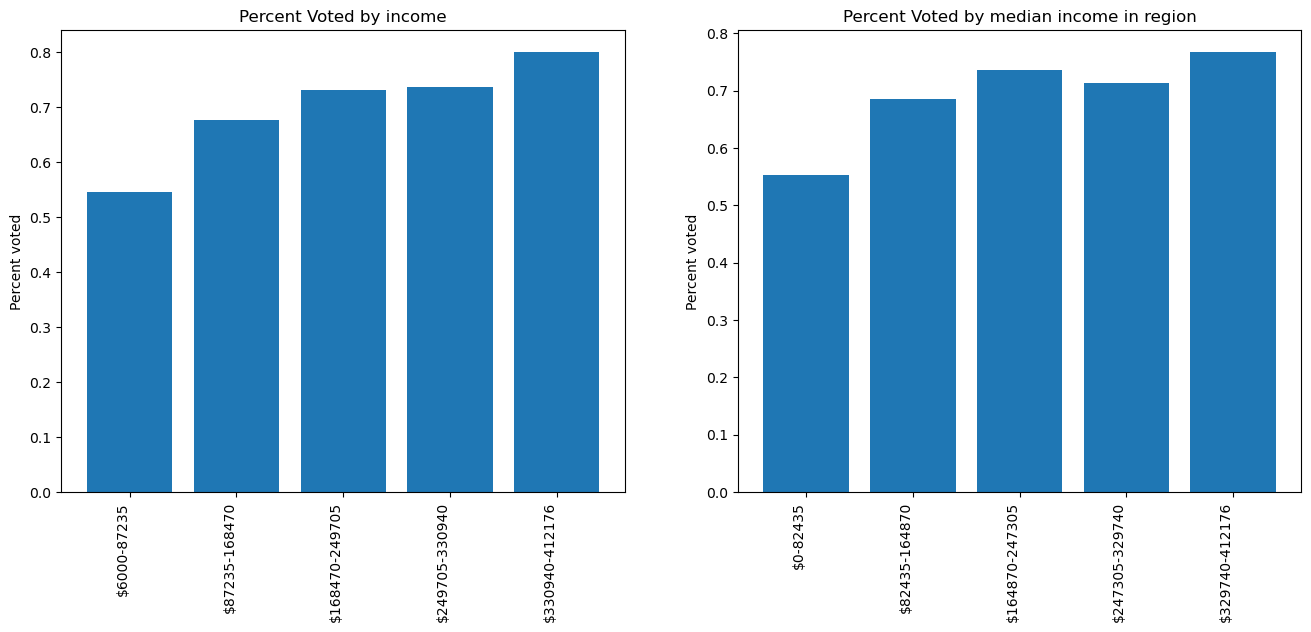

In [219]:
#data2['CommercialData_EstimatedHHIncome'].unique()
#data2['CommercialData_EstimatedAreaMedianHHIncome'].max()

#data2['CommercialData_EstimatedHHIncomeAmount'].min()

#data2['CommercialData_StateIncomeDecile'].unique()



home_value_bin = np.linspace(data2['CommercialData_EstimatedHHIncomeAmount'].min(), data2['CommercialData_EstimatedHHIncomeAmount'].max(), 6).astype('int')
home_value_labels = [f'${home_value_bin[0]}-{home_value_bin[1]}',
                    f'${home_value_bin[1]}-{home_value_bin[2]}',
                    f'${home_value_bin[2]}-{home_value_bin[3]}',
                    f'${home_value_bin[3]}-{home_value_bin[4]}',
                    f'${home_value_bin[4]}-{home_value_bin[5]}',]

binned_col = pd.cut(data2['CommercialData_EstimatedHHIncomeAmount'], home_value_bin, labels=home_value_labels)
data2['CommercialData_EstimatedHHIncomeAmount_binned'] = binned_col
income_value = data2.groupby('CommercialData_EstimatedHHIncomeAmount_binned').mean()['General_2020_bolean'].reset_index()

home_value_bin = np.linspace(data2['CommercialData_EstimatedAreaMedianHHIncome'].min(), data2['CommercialData_EstimatedAreaMedianHHIncome'].max(), 6).astype('int')
home_value_labels = [f'${home_value_bin[0]}-{home_value_bin[1]}',
                    f'${home_value_bin[1]}-{home_value_bin[2]}',
                    f'${home_value_bin[2]}-{home_value_bin[3]}',
                    f'${home_value_bin[3]}-{home_value_bin[4]}',
                    f'${home_value_bin[4]}-{home_value_bin[5]}',]


binned_col = pd.cut(data2['CommercialData_EstimatedAreaMedianHHIncome'], home_value_bin, labels=home_value_labels)
data2['CommercialData_EstimatedAreaMedianHHIncome_binned'] = binned_col
income_value_area = data2.groupby('CommercialData_EstimatedAreaMedianHHIncome_binned').mean()['General_2020_bolean'].reset_index()


plt.figure(figsize=(16, 6))  # Set the figure size
plt.subplot(1,2,1)
plt.bar(income_value['CommercialData_EstimatedHHIncomeAmount_binned'], income_value['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by income')  # Add a title to the chart
plt.xticks(rotation=90, ha='right')

plt.subplot(1,2,2)
plt.bar(income_value_area['CommercialData_EstimatedAreaMedianHHIncome_binned'], income_value_area['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by median income in region') 
plt.xticks(rotation=90, ha='right')






Text(0.5, 1.0, 'Percent voted by difference in regional median income')

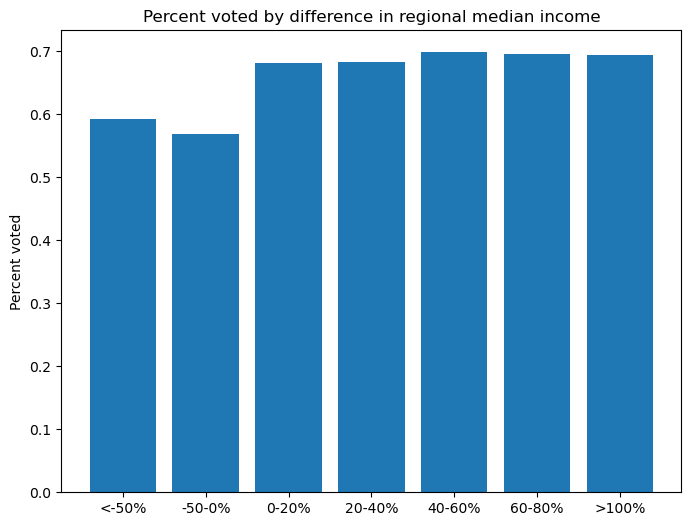

In [224]:
#binned_col = pd.cut(data2['CommercialData_EstHomeValue_in_Dollars'], home_value_bin, labels=home_value_labels)
temp_data = data2[['CommercialData_EstimatedHHIncomeAmount', 'CommercialData_EstimatedAreaMedianHHIncome', 'General_2020_bolean']]

################################# median income is 0 observations are dropped!
temp_data = temp_data[temp_data['CommercialData_EstimatedAreaMedianHHIncome'] != 0]

temp = (temp_data['CommercialData_EstimatedHHIncomeAmount']  \
        - temp_data['CommercialData_EstimatedAreaMedianHHIncome']) \
        / temp_data['CommercialData_EstimatedAreaMedianHHIncome']

temp_data['percent_diff'] = temp


temp_data['percent_diff'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

diff_bin = [-1, -0.5, 0, 0.2, 0.4, 0.6, 0.8, 1]
diff_bin_labels = ['<-50%', '-50-0%', '0-20%', '20-40%', '40-60%', '60-80%', '>100%']


binned_col = pd.cut(temp_data['percent_diff'], diff_bin, labels=diff_bin_labels)
temp_data['diff_binned'] = binned_col
home_value_diff = temp_data.groupby('diff_binned').mean()['General_2020_bolean'].reset_index()

plt.figure(figsize=(8, 6))  # Set the figure size

plt.bar(home_value_diff['diff_binned'], home_value_diff['General_2020_bolean']) 
plt.xlabel('')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent voted by difference in regional median income')  # Add a title to the chart



Text(0.5, 1.0, 'Percent Voted by Regional Education')

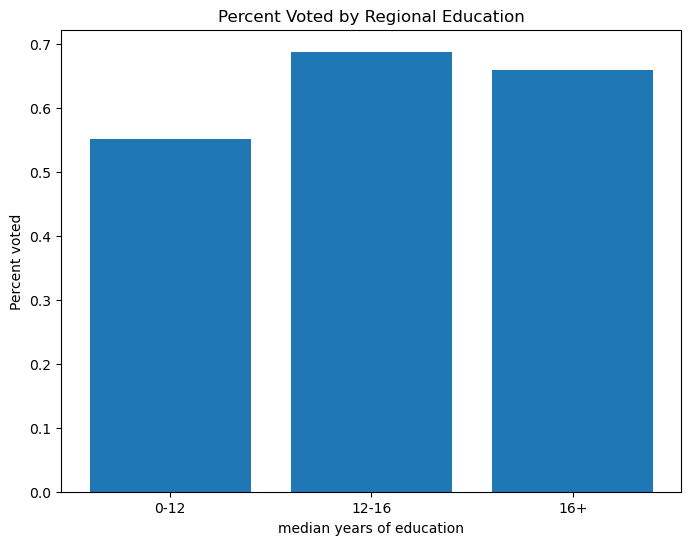

In [198]:
data2['CommercialData_AreaMedianEducationYears']

edu_bin = [0, 12, 16, 5000]
edu_bin_labels = ['0-12', '12-16', '16+']
binned_col = pd.cut(data2['CommercialData_AreaMedianEducationYears'], edu_bin, labels=edu_bin_labels)
data2['CommercialData_AreaMedianEducationYears_binned'] = binned_col
median_education = data2.groupby('CommercialData_AreaMedianEducationYears_binned').mean()['General_2020_bolean'].reset_index()


plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(median_education['CommercialData_AreaMedianEducationYears_binned'], median_education['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('median years of education')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by Regional Education')  # Add a title to the chart




([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

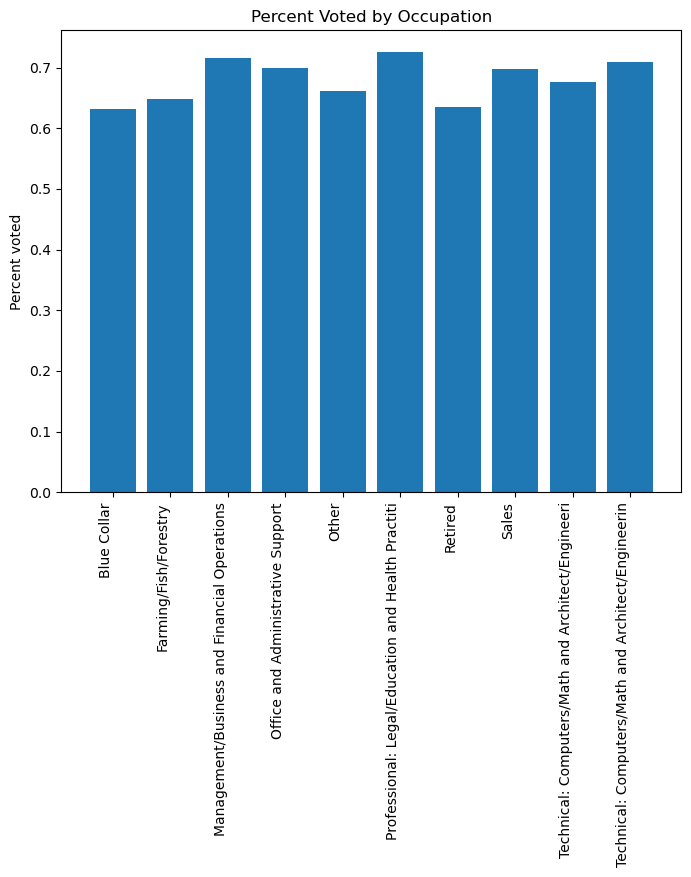

In [217]:
occupation = data2.groupby('CommercialData_OccupationGroup').mean()['General_2020_bolean'].reset_index()


plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(occupation['CommercialData_OccupationGroup'], occupation['General_2020_bolean'])
plt.xlabel('')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by Occupation')  
plt.xticks(rotation=90, ha='right')


In [215]:
#
#data2['CommercialData_LandValue'] #lotts of missing data   
#data2['CommercialData_HomePurchasePrice'] lots of missing data

#data2['CommercialData_PropertyType']
#data2['CommercialDataLL_Home_Owner_Or_Renter'] #somewhat high missing data(about 33 percent missing), categorical


property_type = data2.groupby('CommercialData_PropertyType').mean()['General_2020_bolean'].reset_index()

own_or_rent = data2.groupby('CommercialDataLL_Home_Owner_Or_Renter').mean()['General_2020_bolean'].reset_index()



print(own_or_rent)
print(property_type)



  CommercialDataLL_Home_Owner_Or_Renter  General_2020_bolean
0                      Likely Homeowner             0.708243
1                         Likely Renter             0.557045
  CommercialData_PropertyType  General_2020_bolean
0                   Apartment             0.556506
1                 Condominium             0.714443
2                      Duplex             0.616451
3                  Mobil Home             0.486542
4                 Residential             0.670713
5                     Triplex             0.603587
6                     Unknown             0.520985


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

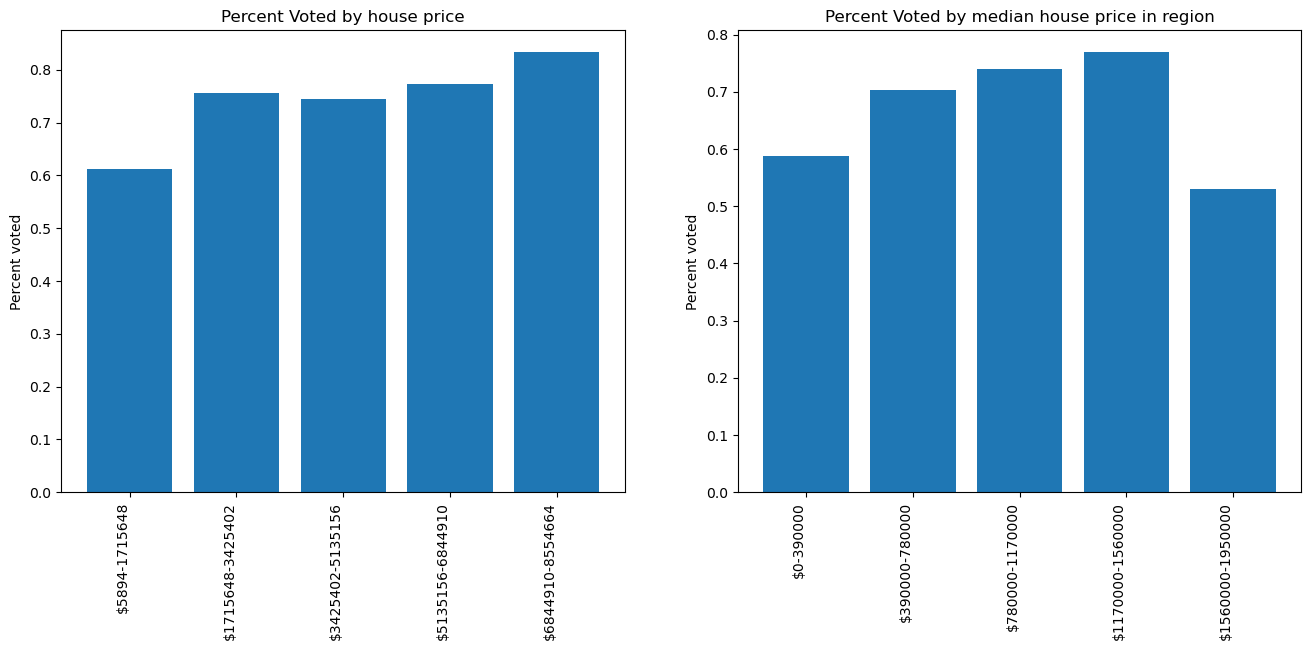

In [108]:
#Home columns data
#Use to convert orignal column to the CommercialData_EstHomeValue_in_Dollars column
#data2['CommercialData_EstHomeValue'] = pd.to_numeric(data2['CommercialData_EstHomeValue'].str.replace('[\$,]', '', regex=True))

import numpy as np

#data2['CommercialData_EstHomeValue_in_Dollars']
#data2['CommercialData_AreaMedianHousingValue']


home_value_bin = np.linspace(data2['CommercialData_EstHomeValue_in_Dollars'].min(), data2['CommercialData_EstHomeValue_in_Dollars'].max(), 6).astype('int')
home_value_labels = [f'${home_value_bin[0]}-{home_value_bin[1]}',
                    f'${home_value_bin[1]}-{home_value_bin[2]}',
                    f'${home_value_bin[2]}-{home_value_bin[3]}',
                    f'${home_value_bin[3]}-{home_value_bin[4]}',
                    f'${home_value_bin[4]}-{home_value_bin[5]}',]

binned_col = pd.cut(data2['CommercialData_EstHomeValue_in_Dollars'], home_value_bin, labels=home_value_labels)
data2['CommercialData_EstHomeValue_in_Dollars_binned'] = binned_col
home_value = data2.groupby('CommercialData_EstHomeValue_in_Dollars_binned').mean()['General_2020_bolean'].reset_index()

home_value_bin = np.linspace(data2['CommercialData_AreaMedianHousingValue'].min(), data2['CommercialData_AreaMedianHousingValue'].max(), 6).astype('int')
home_value_labels = [f'${home_value_bin[0]}-{home_value_bin[1]}',
                    f'${home_value_bin[1]}-{home_value_bin[2]}',
                    f'${home_value_bin[2]}-{home_value_bin[3]}',
                    f'${home_value_bin[3]}-{home_value_bin[4]}',
                    f'${home_value_bin[4]}-{home_value_bin[5]}',]


binned_col = pd.cut(data2['CommercialData_AreaMedianHousingValue'], home_value_bin, labels=home_value_labels)
data2['CommercialData_AreaMedianHousingValue_binned'] = binned_col
home_value_area = data2.groupby('CommercialData_AreaMedianHousingValue_binned').mean()['General_2020_bolean'].reset_index()


plt.figure(figsize=(16, 6))  # Set the figure size
plt.subplot(1,2,1)
plt.bar(home_value['CommercialData_EstHomeValue_in_Dollars_binned'], home_value['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by house price')  # Add a title to the chart
plt.xticks(rotation=90, ha='right')

plt.subplot(1,2,2)
plt.bar(home_value_area['CommercialData_AreaMedianHousingValue_binned'], home_value_area['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by median house price in region') 
plt.xticks(rotation=90, ha='right')



In [88]:
print('hi')

hi


/tmp/ipykernel_426426/2774441584.py:8: FutureWarning: ['Voters_FirstName', 'Voters_LastName', 'LALVOTERID', 'Voters_Gender', 'General_2020', 'Primary_2020', 'Ethnic_Description', 'PresidentialPrimary_2020', 'EthnicGroups_EthnicGroup1Desc', 'CommercialData_Education', 'CommercialData_EstHomeValue', 'CommercialData_EstimatedHHIncome', 'CommercialData_OccupationGroup', 'CommercialData_PropertyType', 'CommercialDataLL_Home_Owner_Or_Renter', 'CommercialData_HomePurchaseDate', 'State', 'CommercialData_AreaPcntHHMarriedCoupleWithChild_binned', 'CommercialData_AreaPcntHHSpanishSpeaking_binned', 'CommercialData_AreaPcntHHWithChildren_binned'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  couple_no_child = data2.groupby('CommercialData_AreaPcntHHMarriedCoupleNoChild_binned').agg(['mean','count'])['General_2020_bolean'].reset_index()
/tmp/ipykernel_426426/2774441584.py:12: FutureWarning: ['Vote

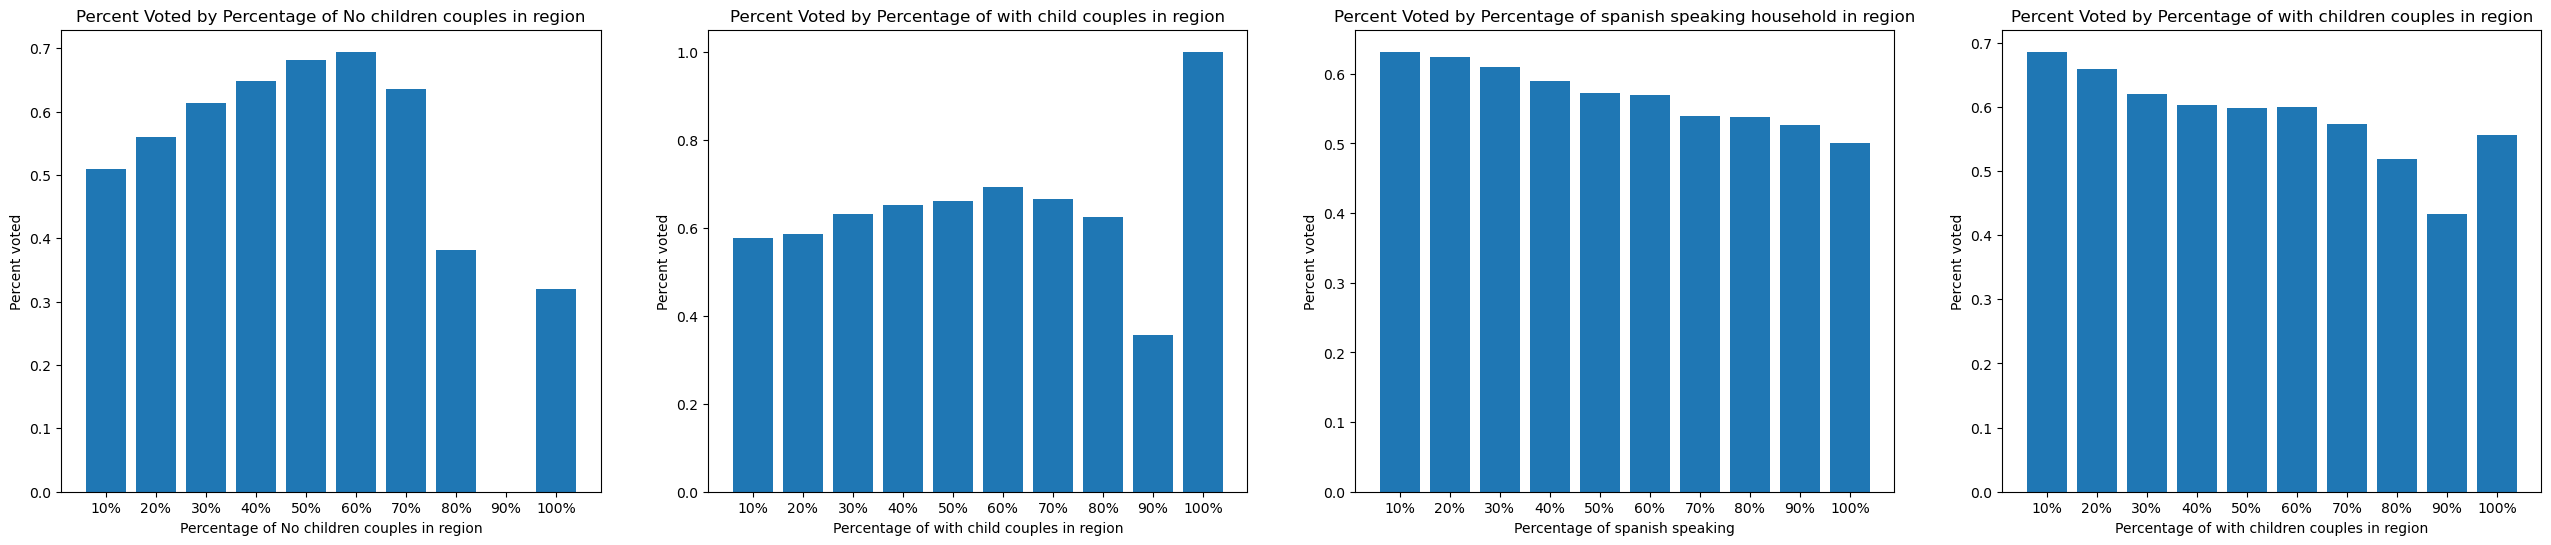

In [65]:
#Percentage columns

data2['General_2020_bolean'] = data2['General_2020'].map({'Y': 1, 'N': 0})

bins = [0,10,20,30,40,50,60,70,80,90,100]
labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%']

percentages = pd.cut(data2['CommercialData_AreaPcntHHMarriedCoupleNoChild'], bins, labels=labels)
data2['CommercialData_AreaPcntHHMarriedCoupleNoChild_binned'] = percentages
couple_no_child = data2.groupby('CommercialData_AreaPcntHHMarriedCoupleNoChild_binned').agg(['mean','count'])['General_2020_bolean'].reset_index()

percentages = pd.cut(data2['CommercialData_AreaPcntHHMarriedCoupleWithChild'], bins, labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%',])
data2['CommercialData_AreaPcntHHMarriedCoupleWithChild_binned'] = percentages
couple_with_child = data2.groupby('CommercialData_AreaPcntHHMarriedCoupleWithChild_binned').agg(['mean','count'])['General_2020_bolean'].reset_index()

percentages = pd.cut(data2['CommercialData_AreaPcntHHSpanishSpeaking'], bins, labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%',])
data2['CommercialData_AreaPcntHHSpanishSpeaking_binned'] = percentages
spanish_speaking = data2.groupby('CommercialData_AreaPcntHHSpanishSpeaking_binned').agg(['mean','count'])['General_2020_bolean'].reset_index()

percentages = pd.cut(data2['CommercialData_AreaPcntHHWithChildren'], bins, labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%',])
data2['CommercialData_AreaPcntHHWithChildren_binned'] = percentages
couple_with_children = data2.groupby('CommercialData_AreaPcntHHWithChildren_binned').agg(['mean','count'])['General_2020_bolean'].reset_index()


# Create a bar chart

plt.figure(figsize=(32, 6))  # Set the figure size
plt.subplot(1,4,1)
plt.bar(couple_no_child['CommercialData_AreaPcntHHMarriedCoupleNoChild_binned'], couple_no_child['mean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('Percentage of No children couples in region')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by Percentage of No children couples in region')  # Add a title to the chart

plt.subplot(1,4,2)
plt.bar(couple_with_child['CommercialData_AreaPcntHHMarriedCoupleWithChild_binned'], couple_with_child['mean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('Percentage of with child couples in region')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by Percentage of with child couples in region')  # Add a title to the chart

plt.subplot(1,4,3)
plt.bar(spanish_speaking['CommercialData_AreaPcntHHSpanishSpeaking_binned'], spanish_speaking['mean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('Percentage of spanish speaking')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by Percentage of spanish speaking household in region')  # Add a title to the chart

plt.subplot(1,4,4)
plt.bar(couple_with_children['CommercialData_AreaPcntHHWithChildren_binned'], couple_with_children['mean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('Percentage of with children couples in region')  # Label the x-axis
plt.ylabel('Percent voted')  # Label the y-axis
plt.title('Percent Voted by Percentage of with children couples in region')  # Add a title to the chart

plt.show()





In [62]:
couple_no_child

,CommercialData_AreaPcntHHMarriedCoupleNoChild_binned,mean,count
0,10%,0.509708,16276
1,20%,0.559779,75076
2,30%,0.613293,109530
3,40%,0.648398,96248
4,50%,0.682251,30886
5,60%,0.694547,1889
6,70%,0.636364,154
7,80%,0.380952,21
8,90%,0.000000,2
9,100%,0.320000,25


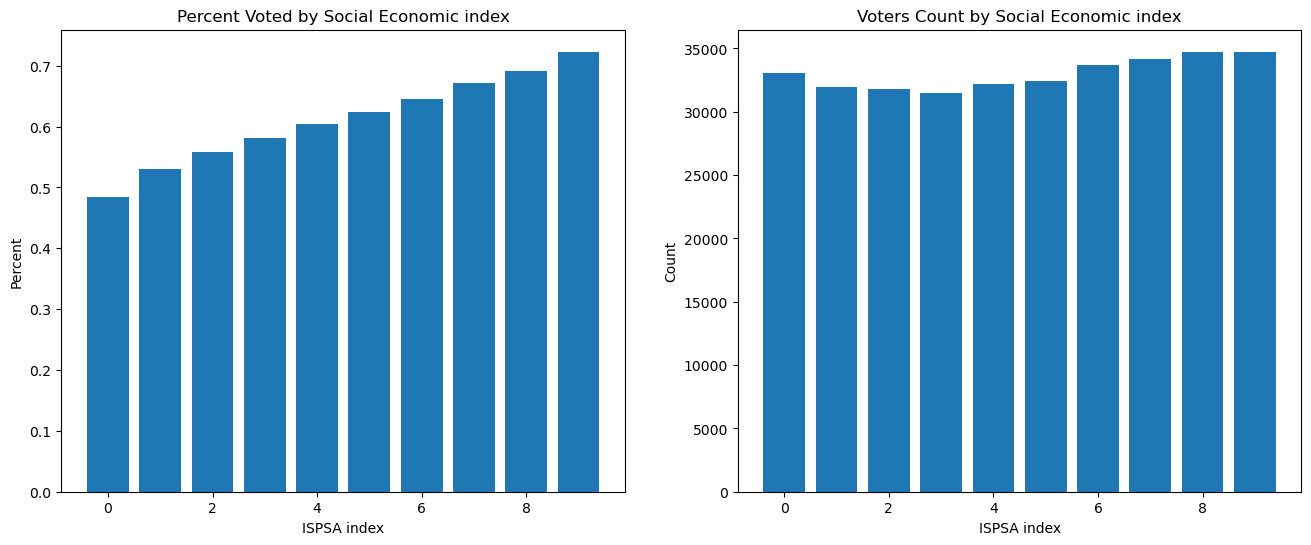

In [40]:
data2['General_2020_bolean'] = data2['General_2020'].map({'Y': 1, 'N': 0})


ISPSA = data2.groupby('CommercialData_ISPSA').agg('mean')['General_2020_bolean']
ISPSA = ISPSA.reset_index()

ISPSA_count = data2.groupby('CommercialData_ISPSA').agg('count')['General_2020_bolean']
ISPSA_count = ISPSA_count.reset_index()

import pandas as pd
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(16, 6))  # Set the figure size
plt.subplot(1,2,1)
plt.bar(ISPSA['CommercialData_ISPSA'], ISPSA['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('ISPSA index')  # Label the x-axis
plt.ylabel('Percent')  # Label the y-axis
plt.title('Percent Voted by Social Economic index')  # Add a title to the chart

plt.subplot(1,2,2)
plt.bar(ISPSA_count['CommercialData_ISPSA'], ISPSA_count['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('ISPSA index')  # Label the x-axis
plt.ylabel('Count')  # Label the y-axis
plt.title('Voters Count by Social Economic index')  # Add a title to the chart

# Display the bar chart
plt.show()


                 

### CommercialData_StateIncomeDecile

import pandas as pd
import matplotlib.pyplot as plt
#data2['General_2020_bolean'] = data2['General_2020'].map({'Y': 1, 'N': 0})





decile = data2.groupby('CommercialData_StateIncomeDecile').agg('mean')['General_2020_bolean'].reset_index()
# Create a bar chart
plt.figure(figsize=(8, 6))  # Set the figure size

plt.bar(decile['CommercialData_StateIncomeDecile'], decile['General_2020_bolean'])  # Create bars with 'a' on x-axis and 'b' on y-axis
plt.xlabel('StateIncomeDecile index')  # Label the x-axis
plt.ylabel('Percent')  # Label the y-axis
plt.title('Percent Voted by state income decile')  # Add a title to the chart


plt.show()

